### LIBRARIES

In [1]:
# Setup
!pip install segmentation-models-pytorch
# !pip install --upgrade pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 880.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=04643ceedca1234765b74f62bd1aa1766b81db51a3d14b32d07ba0159c53cc71
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=acbcc34b05f3c64a799ca36dc1cd2435c86958f16f0a9577f1098774f971b5e4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset
import tifffile as tiff
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Model & Modelling
import torch
from torchvision.transforms import functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as smp_loss
from sklearn.model_selection import StratifiedShuffleSplit

from typing import Optional, List

### UTILITIES

In [3]:
# Viz.
def plot_sample(
    ax,
    item,
    annotate: Optional[bool] = False,
    is_transformed: Optional[bool] = False
):
    """
    Plot a specified samples.
    
    Parameters
    ----------
    ax
        A dataframe with the metadata on the samples.
    item
        A pytorch Dataset instance.
    annotate
        Optionally, whether to annotate the samples or not.
    is_transformed
        Optionally, whether the dataset has been transformed 
        specifically to a pytorch tensor.
    """
    # Show image.
    if is_transformed:
        ax.imshow(np.transpose(item['image'], [1, 2, 0]))
    else:
        ax.imshow(item['image'])
    
    # Add annotations if necessary.
    if annotate:
        ax.imshow(item['mask'],cmap='coolwarm', alpha=0.3)

    ax.axis("off")
    # 0: Organ, 4: Sex
    ax.set_title(f"{item['metadata'].organ}, {item['metadata'].sex}")
    
    

def plot_samples(
    dataset,
    indices: list,
    annotate: bool = False,
    cols: int = 2,
    figsize: tuple = (18, 5),
    is_transformed: Optional[bool] = False
):
    """
    Plot a grid of specified samples.
    
    Parameters
    ----------
    hhhhb_dataset
        A pytorch Dataset object.
    indices
        A list of the item indices to plot.
    annotate
        Optionally, whether to annotate the samples or not.
    cols
        Optionally, the number of columns for the grid.
    figsize
        Optionally, a tuple containg the figure size in the form (width, height).
    is_transformed
        Optionally, whether the dataset has been transformed 
        specifically to a pytorch tensor.
    """
    # Infer rows.
    items = len(indices)
    rows, x = items // cols, items % cols # x carries the reminder if it exists.
    rows = rows if x == 0 else rows + 1
    
    # Set up figure.
    if not (isinstance(figsize, tuple) and len(figsize)==2):
        raise ValueError("Please provide a valid figsize i.e. (width, height)")
    fig = plt.figure(figsize=(figsize[0], figsize[1] * rows))
    
    # Plotting loop.
    for idx, index in enumerate(indices):
        ax = fig.add_subplot(rows, cols, idx + 1)
        plot_sample(ax, dataset[index], annotate, is_transformed)
        
    plt.tight_layout()

In [4]:
def mask2rle(
    mask:np.array
):
    """
    Encode mask using run length encoding.
    
    Parameters
    ----------
    mask
         A numpy array, 1 - mask, 0 - background
    
    Returns
    -------
    A run length encoding of the mask as a string formated.
    
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(
    mask_rle: str, 
    shape: tuple= (3000,3000)
):
    """
    Convert a run length encoding to a mask.
    
    Parameters
    ----------
    mask_rle
        A run-length as string formated (start length).
    shape
        The shape of the image to which the rle is to be unencoded (width,height).
        
    Returns
    -------
        A numpy array, 1 - mask, 0 - background.
        
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
# The dataset.
class HHHHBDataset(Dataset):
    """
    Reads in images, transfroms pixel values and serves a dictionary containing the image ids,
    image tensors and the label masks.
    """
    def __init__(
        self,
        data: pd.DataFrame,
        transforms: Optional[list] = None,
        metadata: Optional[bool] = False
    ):
        """
        Instantiate the HHHHBDataset.
        
        Parameters
        ----------
        data
            A dataframe with a row for each biopsy image.
        transforms
            Optionally, a list of transforms to apply to the feature data. (Augmentations).
        metadata
            Optionally, add metadata to the returned dictionary, necessary for plotting and evaluation
            but not model training.
        """
        self.data = data
        self.transforms = transforms
        self.metadata = metadata
        
    def __len__(self):
        return self.data['id'].nunique()
    
    def __getitem__(
        self, 
        idx: int
    ):
        # Loads an n-channel image from a chip-level dataframe.
        img_metadata = self.data.loc[idx]
        
        # Read in the image.
        img_arr = tiff.imread(img_metadata.file_path)
        
        # Load mask.
        mask_arr = rle2mask(img_metadata.rle, (img_metadata.img_width, img_metadata.img_height))
        
        # Apply data augmentations, if provided.
        if self.transforms:
            augmented = self.transforms(image=img_arr, mask=mask_arr)
            # Get augmentations.
            img_arr = augmented['image']
            mask_arr = augmented['mask']
        
        # Prepare the dictionary for item.
        item = {
            "id": img_metadata["id"], 
            "image": img_arr, # Change from HxWxC to CxHxW for pytorch. ToTensorV2
            "mask": mask_arr
        }
        
        # Add metadata.
        if self.metadata:
            item["metadata"] = img_metadata[['organ', 'pixel_size', 'tissue_thickness', 'age', 'sex']]
        return item

In [6]:
# The model.
class HHHHBModel(pl.LightningModule):
    def __init__(
        self,
        train: Optional[pd.DataFrame],
        val: Optional[pd.DataFrame],
        hparams: Optional[dict] = {}
    ):
        """
        Instantiate the HHHHBModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).
        
        Parameters
        ----------
        train
            A dataframe of the training features with a row for each sample.
            There must be a column for the sample id, an rle column containing the training labels (mask)
            and file_path with the path to the TIF for each sample.
        val
            A dataframe of the validation features with a row for each sample.
        hparams
            A dictionary of with additional modeling parameters.
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters(ignore=["train", "val"])

        # optional modeling params
        self.backbone = self.hparams.get("backbone", "resnet50")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.train_transforms = self.hparams.get("train_transforms", None)
        self.val_transforms = self.hparams.get("val_transforms", None)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)

        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = HHHHBDataset(data=train, transforms=self.train_transforms)
        self.val_dataset = HHHHBDataset(data=val, transforms=self.val_transforms)
        self.model = self._prepare_model()

    ## Required LightningModule methods ##

    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.
        
        Parameters
        ----------
        batch
            A dictionary of items from HHHHBDataset of the form
            {'id': list[int], 'image': list[torch.Tensor], 'mask': list[torch.Tensor]]}
        batch_idx
            The batch number.
        """
        if self.train_dataset.data is None:
            raise ValueError("data parameter must be specified when HHHHBModel is instantiated to run training.")

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["image"]
        y = batch["mask"].long()
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        preds = self.forward(x) # Forward pass
        loss = smp_loss.DiceLoss(mode='binary', smooth=1.0)(preds, y).mean()
        self.log("train_score", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True) # Log batch loss.
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.
        
        Parameters
        ----------
        batch
            A dictionary of items from HHHHBDataset of the form
            {'id': list[int], 'image': list[torch.Tensor], 'mask': list[torch.Tensor]}
        batch_idx
            The batch number
        """
        if self.val_dataset.data is None:
            raise ValueError("Specify a validation dataset to run validation.")

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["image"]
        y = batch["mask"]
        
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass 
        preds = self.forward(x)
        # preds = torch.nn.functional.logsigmoid(preds).exp()
        # preds = (preds > 0.5) * 1  # convert to int

        # Log batch IOU  
        batch_dice_score = smp_loss.DiceLoss(mode='binary', smooth=1.0)(preds, y).mean()
        self.log("val_score", batch_dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return batch_dice_score

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    ## Convenience Methods ##

    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=3,
            classes=1,
        )
        if self.gpu:
            unet_model.cuda()

        return unet_model

### DATA
Preliminary EDA [here.](https://www.kaggle.com/code/bomera/hhhhb-eda)

In [7]:
data_path = '../input/hubmap-organ-segmentation' # Path to the data.
dataset = pd.read_csv(f"{data_path}/train.csv")
test = pd.read_csv(f"{data_path}/test.csv")
submission = pd.read_csv(f"{data_path}/sample_submission.csv")

In [8]:
# Add file paths.
dataset['file_path'] = data_path + '/train_images/' + dataset['id'].astype(str) + '.tiff'

### DATASET

In [9]:
# Test Augmentations.
transforms = A.Compose([
    A.Resize(1280, 1280),
    A.HorizontalFlip(),
    ToTensorV2()
])

# No transforms.
hhhhb_dataset = HHHHBDataset(dataset, metadata=True) 
# Test transforms.
hhhhb_datasetT= HHHHBDataset(dataset, transforms=transforms, metadata=True) 
len(hhhhb_datasetT), len(hhhhb_dataset)

(351, 351)

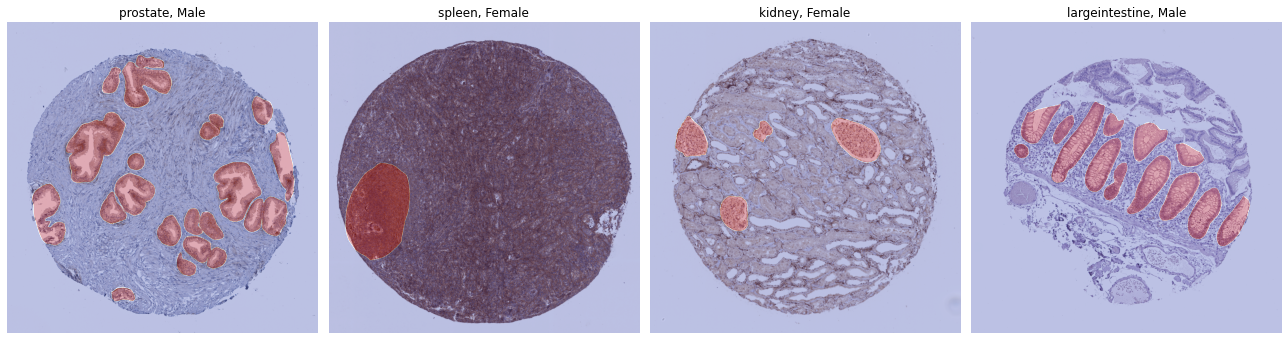

In [10]:
plot_samples(hhhhb_dataset, indices=[1, 4, 5, 6], annotate=True, cols=4)

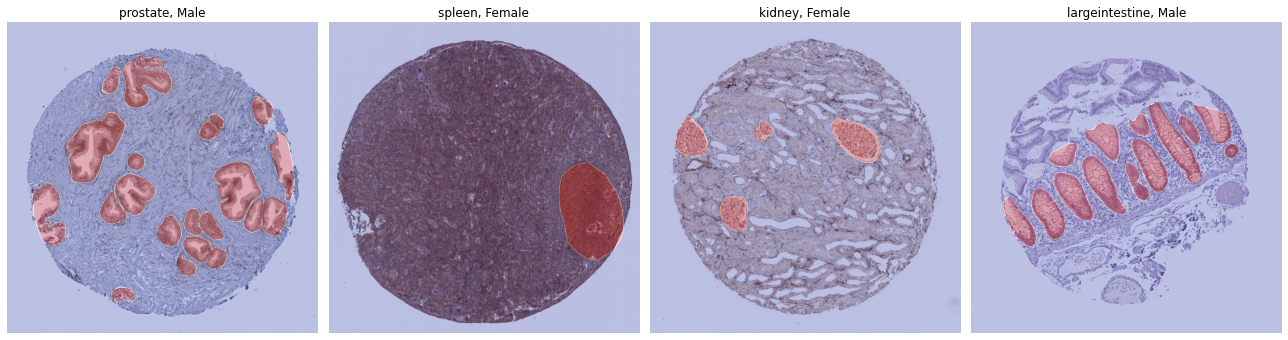

In [11]:
plot_samples(hhhhb_datasetT, indices=[1, 4, 5, 6], annotate=True, cols=4, is_transformed=True)

#### LOSS FUNCTION

In [12]:
# Loss function check.
loss = smp.losses.DiceLoss(mode='binary', from_logits=False)
loss(F.to_tensor(hhhhb_dataset[0]['mask']), F.to_tensor(hhhhb_dataset[0]['mask']))

tensor(0.9961)

In [13]:
# Clear RAM
del hhhhb_dataset
del hhhhb_datasetT

#### VALIDATION SET

In [14]:
# Check for distributions on organs and sex.
# dataset.groupby(['organ', 'sex'])['id'].count()
dataset['organ'].value_counts(normalize=True)

kidney            0.282051
prostate          0.264957
largeintestine    0.165242
spleen            0.150997
lung              0.136752
Name: organ, dtype: float64

In [15]:
# Split across the organs.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in split.split(dataset, dataset['organ']):
    train, val = dataset.loc[train_idx].reset_index(drop=True), dataset.loc[val_idx].reset_index(drop=True)

In [16]:
train['organ'].value_counts(normalize=True), val['organ'].value_counts(normalize=True)

(kidney            0.282540
 prostate          0.263492
 largeintestine    0.165079
 spleen            0.152381
 lung              0.136508
 Name: organ, dtype: float64,
 prostate          0.277778
 kidney            0.277778
 largeintestine    0.166667
 lung              0.138889
 spleen            0.138889
 Name: organ, dtype: float64)

### MODELLING

In [17]:
# train transforms
train_transforms = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

# val transforms
val_transforms = A.Compose([
    A.Resize(640, 640),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

# hparams
hparams = {"num_workers": 2, "batch_size": 4, "train_transforms": train_transforms, "val_transforms": val_transforms}

# Set up trainer object.
hhhhb_model = HHHHBModel(train, val, hparams=hparams)

# Set up call backs.
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_score", mode="max", verbose=True)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_score", patience=(hhhhb_model.patience * 3), mode="max",verbose=True)

# Set up trainer.
trainer = pl.Trainer(
    accelerator='gpu',
    fast_dev_run=False,
    max_epochs=10,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
# Fit the model.
trainer.fit(model=hhhhb_model)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]